In [1]:
#%load_ext watermark
#%watermark -a 'Ouedraogo Clovis' -u -d -v -m

## Imports

In [2]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler
from joblib import dump

from aqosd_experiments.config import CLASSIFIERS, PARAM_GRIDS, RAW_DATASET_PATH, HOST_LIST, CV, MODELS_PATH, FIG_PATH
from aqosd_experiments.data import import_and_prepare_data, scale_metrics, over_sampling
from aqosd_experiments.plot import plot_number_of_instance, plot_osdm, plt_long_stats, plt_corr_metrics, \
    plot_multicollinear_metrics, plt_corr_bottlenecks, plt_all_data
from aqosd_experiments.scorers import process_score, SCORING
from osms import OverheadSensitiveMetricSelection

## Load Config

In [3]:
%whos str  int  tuple OrderedDict

Variable           Type           Data/Info
-------------------------------------------
CLASSIFIERS        OrderedDict    OrderedDict([('DummyClass<...>ti Label kNN', MLkNN())])
FIG_PATH           str            C:/Users/couedrao/Pycharm<...>/../data/output/plotting/
HOST_LIST          tuple          n=4
MODELS_PATH        str            C:/Users/couedrao/Pycharm<...>data/output/saved_models/
RAW_DATASET_PATH   str            C:/Users/couedrao/Pycharm<...>ents/../data/raw_dataset/
SCORING            OrderedDict    OrderedDict([('subset acc<...>_scorer(zero_one_loss))])


In [4]:
#raw_dataset_path, host_list, models_path, fig_path= RAW_DATASET_PATH,  HOST_LIST, MODELS_PATH, FIG_PATH
#classifiers,param_grids = CLASSIFIERS, PARAM_GRIDS
#scoring, cv = SCORING, CV
save=False

## Load and prepare data

In [5]:
metrics, bottlenecks = import_and_prepare_data(RAW_DATASET_PATH, HOST_LIST)
print('Shape of metrics : ',metrics.shape,'\t','Shape of bottlenecks : ',bottlenecks.shape) #42813
print('Label cardinality = %.5f \t Label density = %.5f' % (bottlenecks.sum(axis=1).mean(),
                                                           bottlenecks.mean(axis=1).mean()))

Shape of metrics :  (42813, 104) 	 Shape of bottlenecks :  (42813, 32)
Label cardinality = 2.02312 	 Label density = 0.06322


In [6]:
metrics=scale_metrics(metrics, MinMaxScaler()) 
print('Shape of metrics : ',metrics.shape,'\t','Shape of bottlenecks : ',bottlenecks.shape)

Shape of metrics :  (42813, 104) 	 Shape of bottlenecks :  (42813, 32)


In [7]:
metric_names, bottleneck_names = list(metrics.columns), list(bottlenecks.columns)
print(metric_names)
print(100*'-')
print(bottleneck_names)

['SRV./: Free inodes in %', 'SRV./: Space utilization', 'SRV./: Used space', 'SRV./boot: Free inodes in %', 'SRV./boot: Space utilization', 'SRV./boot: Used space', 'SRV.Available memory', 'SRV.Available memory in %', 'SRV.CPU idle time', 'SRV.CPU iowait time', 'SRV.CPU softirq time', 'SRV.CPU system time', 'SRV.CPU user time', 'SRV.CPU utilization', 'SRV.Context switches per second', 'SRV.Free swap space', 'SRV.Free swap space in %', 'SRV.Interface enp0s8: Bits received', 'SRV.Interface enp0s8: Bits sent', 'SRV.Interrupts per second', 'SRV.Load average (15m avg)', 'SRV.Load average (1m avg)', 'SRV.Load average (5m avg)', 'SRV.Memory utilization', 'SRV.Number of processes', 'SRV.Number of running processes', 'GW1./: Free inodes in %', 'GW1./: Space utilization', 'GW1./: Used space', 'GW1./boot: Free inodes in %', 'GW1./boot: Space utilization', 'GW1./boot: Used space', 'GW1.Available memory', 'GW1.Available memory in %', 'GW1.CPU idle time', 'GW1.CPU iowait time', 'GW1.CPU softirq time

In [8]:
metrics.head()

SRV./: Free inodes in %  SRV./: Space utilization  \
cycle                                                                    
2020-12-13 18:14:37                      0.0                       0.0   
2020-12-13 18:14:38                      0.0                       0.0   
2020-12-13 18:14:39                      0.0                       0.0   
2020-12-13 18:14:40                      0.0                       0.0   
2020-12-13 18:14:42                      0.0                       0.0   

                     SRV./: Used space  SRV./boot: Free inodes in %  \
cycle                                                                 
2020-12-13 18:14:37                0.0                          0.0   
2020-12-13 18:14:38                0.0                          0.0   
2020-12-13 18:14:39                0.0                          0.0   
2020-12-13 18:14:40                0.0                          0.0   
2020-12-13 18:14:42                0.0                          0.0   

                     SRV./boot: Space utilization  SRV./boot: Used space  \
cycle                                                                      
2020-12-13 18:14:37                           0.0                    0.0   
2020-12-13 18:14:38                           0.0                    0.0   
2020-12-13 18:14:39                           0.0                    0.0   
2020-12-13 18:14:40                           0.0                    0.0   
2020-12-13 18:14:42                           0.0                    0.0   

                     SRV.Available memory  SRV.Available memory in %  \
cycle                                                                  
2020-12-13 18:14:37                   0.0                        0.0   
2020-12-13 18:14:38                   0.0                        0.0   
2020-12-13 18:14:39                   0.0                        0.0   
2020-12-13 18:14:40                   0.0                        0.0   
2020-12-13 18:14:42                   0.0                        0.0   

                     SRV.CPU idle time  SRV.CPU iowait time  ...  \
cycle                                                        ...   
2020-12-13 18:14:37                0.0                  0.0  ...   
2020-12-13 18:14:38                0.0                  0.0  ...   
2020-12-13 18:14:39                0.0                  0.0  ...   
2020-12-13 18:14:40                0.0                  0.0  ...   
2020-12-13 18:14:42                0.0                  0.0  ...   

                     GW111.Free swap space in %  \
cycle                                             
2020-12-13 18:14:37                         0.0   
2020-12-13 18:14:38                         0.0   
2020-12-13 18:14:39                         0.0   
2020-12-13 18:14:40                         0.0   
2020-12-13 18:14:42                         0.0   

                     GW111.Interface enp0s8: Bits received  \
cycle                                                        
2020-12-13 18:14:37                                    0.0   
2020-12-13 18:14:38                                    0.0   
2020-12-13 18:14:39                                    0.0   
2020-12-13 18:14:40                                    0.0   
2020-12-13 18:14:42                                    0.0   

                     GW111.Interface enp0s8: Bits sent  \
cycle                                                    
2020-12-13 18:14:37                           0.000000   
2020-12-13 18:14:38                           0.000000   
2020-12-13 18:14:39                           0.000000   
2020-12-13 18:14:40                           0.000000   
2020-12-13 18:14:42                           0.492201   

                     GW111.Interrupts per second  \
cycle                                              
2020-12-13 18:14:37                          0.0   
2020-12-13 18:14:38                          0.0   
2020-12-13 18:14:39                          0.0   
2020-12-13 18:14:40          

In [9]:
#bottlenecks.describe()

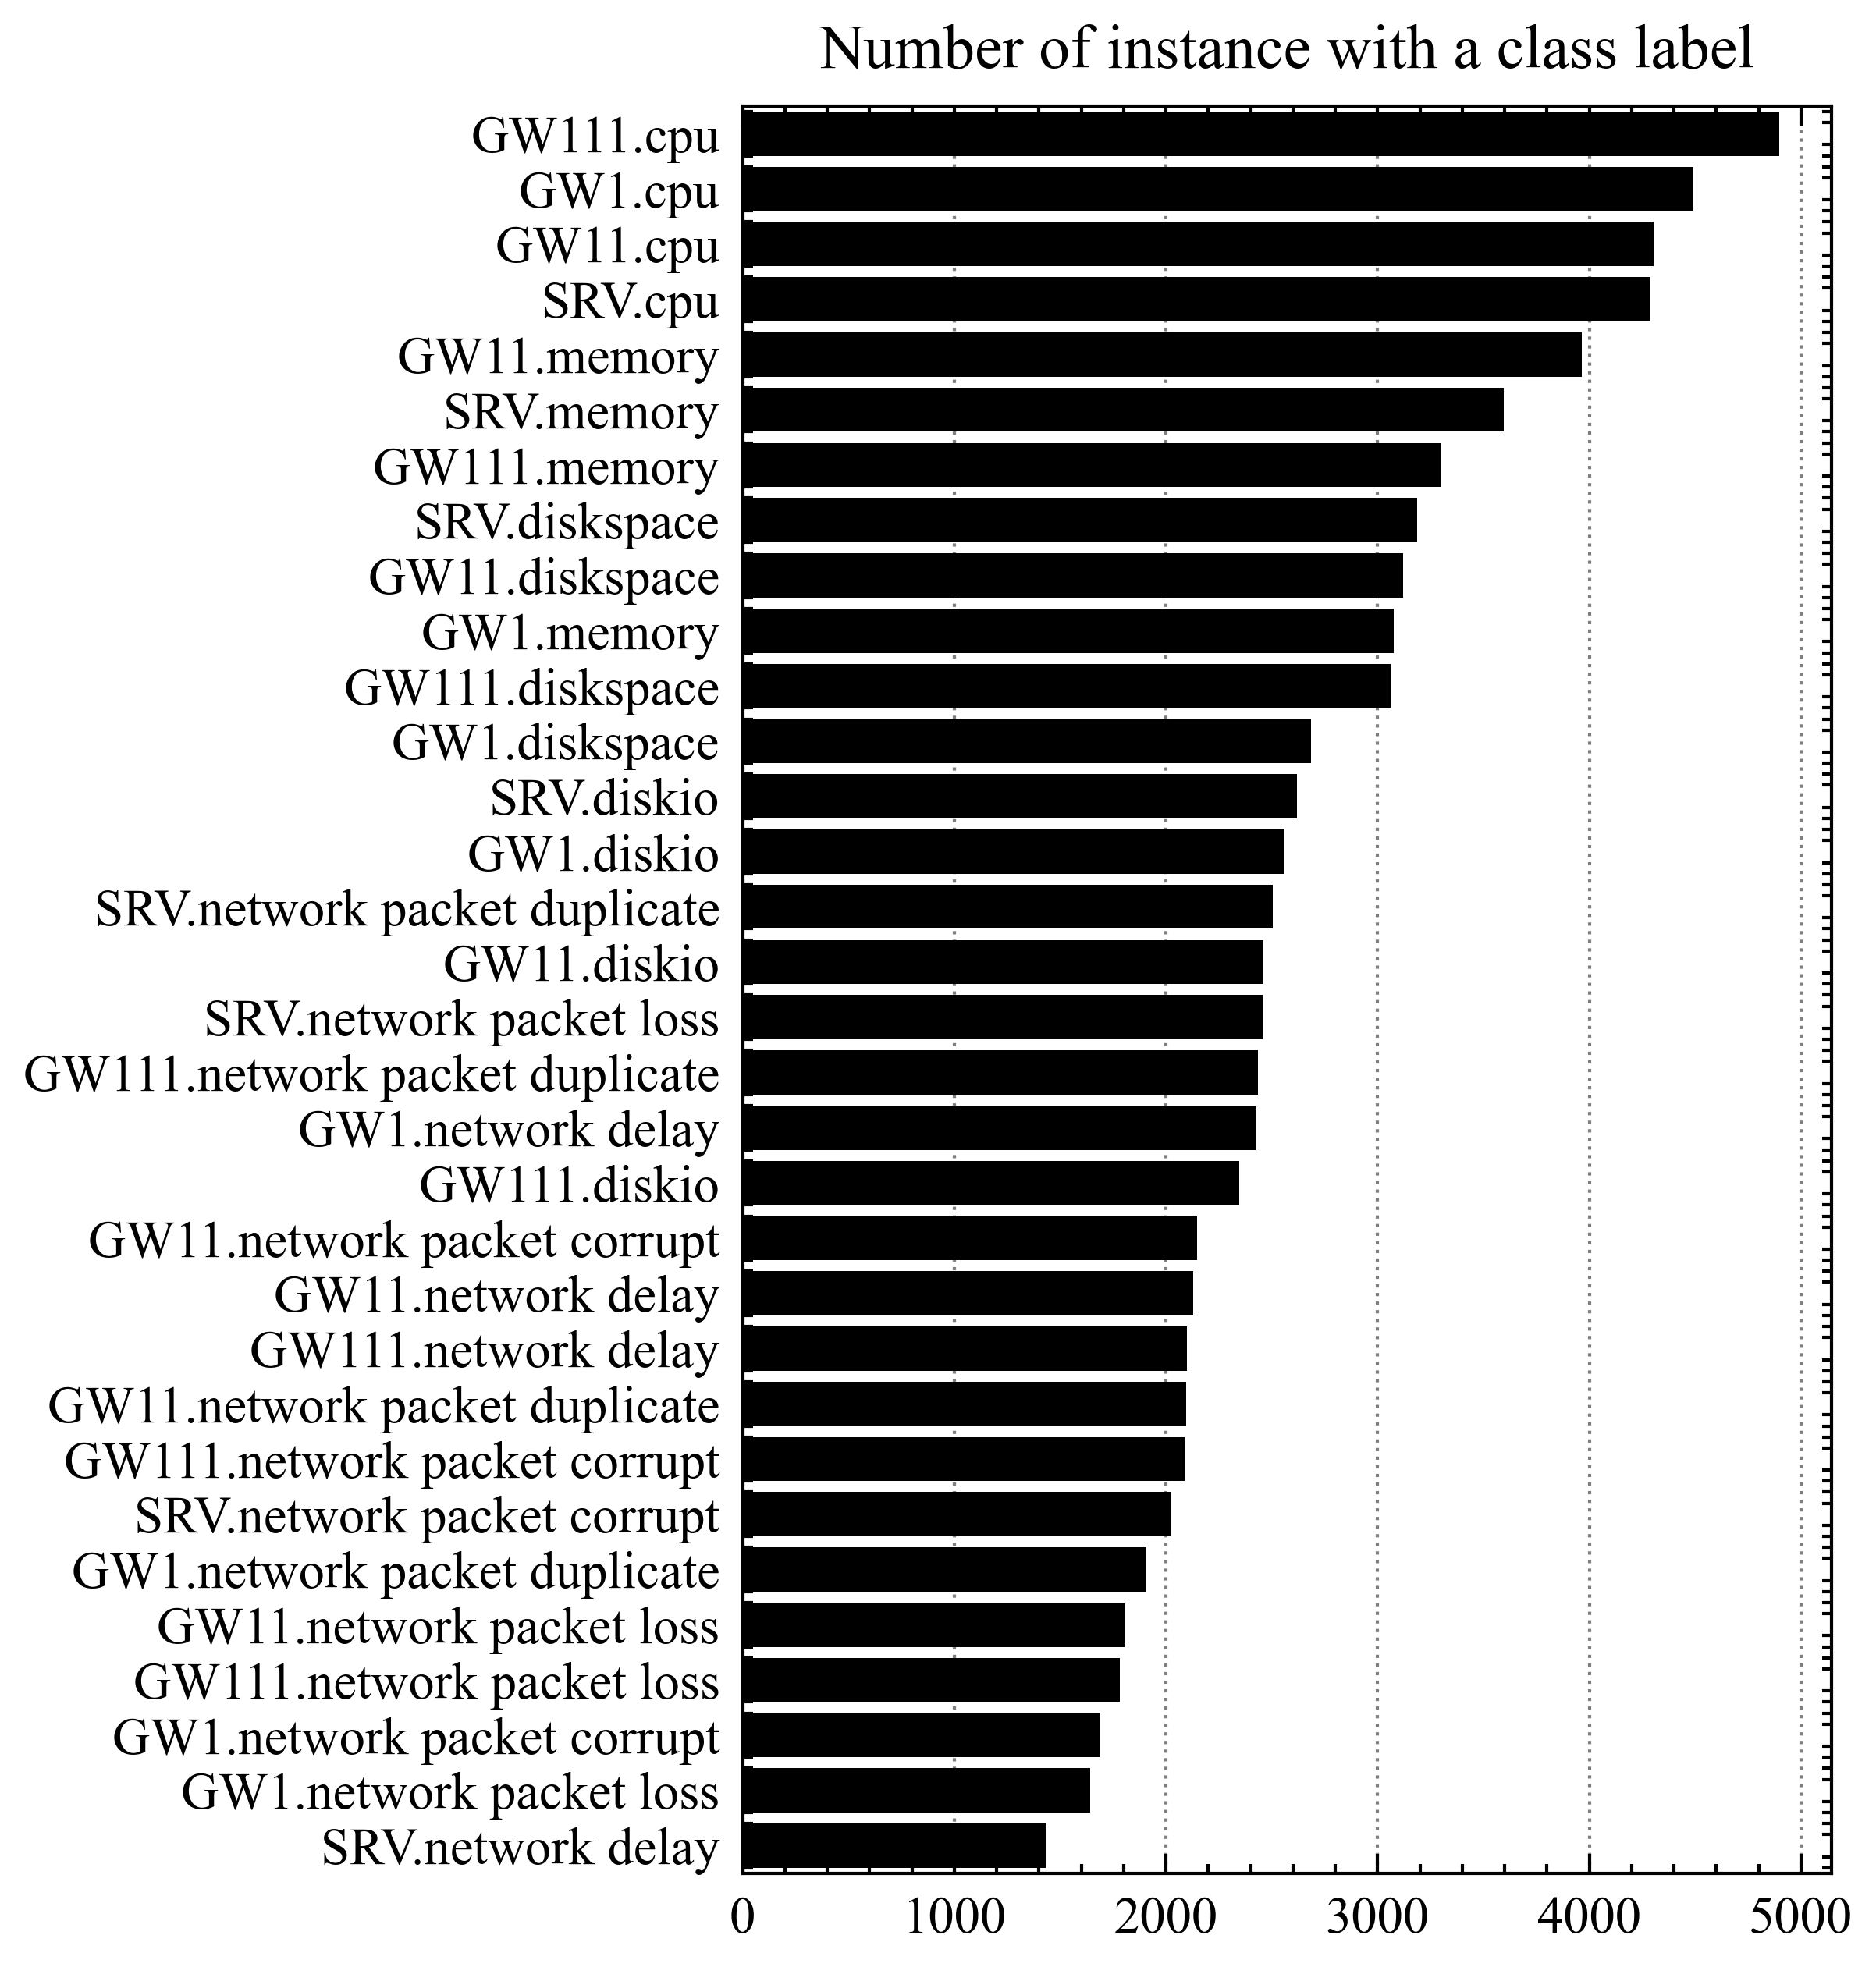

In [10]:
fig = plot_number_of_instance(bottlenecks)
if save:
    fig.savefig(fig_path + "Number_of_instance_with_a_class_label.pdf", bbox_inches='tight')

In [11]:
fig = plt_corr_metrics(metrics, c3='w', method='spearman')
if save:
    fig.savefig(fig_path + "Correlation in Metrics.pdf", bbox_inches='tight')

In [ ]:
results=pd.DataFrame()
for clf_name, clf in CLASSIFIERS.items():
    start=time.time()
    print(100*'-')
    print('##', clf_name.ljust(20), end=' ')
    scores = cross_validate(clf, metrics.values, bottlenecks.values, cv=CV, scoring=SCORING,verbose=0, n_jobs=-1,
                            return_train_score=True, )
    results = pd.concat([results,  process_score(clf_name, scores, SCORING)])
    print('>','time:',(time.time()-start)//60+1,'minutes', '\t','|', 'score:', np.mean(scores['test_subset accuracy']))
    
if save:
    results.T.to_csv(models_path + 'benchmark_results.csv', index=True)
results.T

--------------------------------------------------
## DummyClassifier
-----> time: 1.0 minutes
--------------------------------------------------
--------------------------------------------------
## Extra Tree
-----> time: 1.0 minutes
--------------------------------------------------
--------------------------------------------------
## Decision Tree
-----> time: 2.0 minutes
--------------------------------------------------
--------------------------------------------------
## Random Forest


In [ ]:
n_metric_SRV = sum(1 for s in metric_names if 'SRV.' in s)
n_metric_GW1 = sum(1 for s in metric_names if 'GW1.' in s)
n_metric_GW11 = sum(1 for s in metric_names if 'GW11.' in s)
n_metric_GW111 = sum(1 for s in metric_names if 'GW111.' in s)
print("n_metric : { SRV : ",n_metric_SRV,", GW1 : ",n_metric_GW1, ", GW11 : ",n_metric_GW11, 
      ", GW111 : ",n_metric_GW111,"}")

## Scenario 4 : Limited budget (1/4 total overhead) + Overhead increases by a factor of 0.5 from SRV --> GW111

## Scenario 3 : Limited budget (1/2 total overhead) + Overhead increases by a factor of 0.5 from SRV --> GW111

## Scenario 2 : Limited budget (1/4 total overhead) + Same overhead for all metrics

## Scenario 1 : Limited budget (1/2 total overhead) + Same overhead for all metrics

## Scenario 0 : Unlimited budget + Same overhead for all metrics